## Firstly we set up 8 dask workers

In [1]:
import numpy as np
import dask
from dask.distributed import Client, LocalCluster
import dask.bag as db

In [2]:
cluster = LocalCluster(n_workers=8)
# explicitly connect to the cluster we just created
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:34929 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 62.03 GiB


## And we define a function

$$
g(x) = \sqrt{|x|} ^{\ln |x|}
$$

This is a test function for each pixel. In the real case we use an optimization workflow for each pixel.

In [4]:
def g(x):
    
    p_list = np.linspace(-5, 5, 10000)
    results_collection = np.zeros_like(p_list)
    for i, p in enumerate(p_list):
        results_collection[i] = np.sqrt(np.abs(x)) ** np.log(np.abs(x - p))
    ideal_p_idx = np.argmin(results_collection)
    return p_list[ideal_p_idx]

g(-0.1111)

5.0

## ...and a large array

with 2 million pixels. Pixel values are normally distributed.

In [5]:
array_size = 100
test_array = np.random.randn(array_size)

Now we are going to apply $g(x)$ to each pixel in the test array.

## Serial

In [6]:
%%time

results_serial = np.zeros((array_size, 1))
for i in range(len(test_array)):
    results_serial[i] = g(test_array[i])

CPU times: user 5.11 s, sys: 9.49 ms, total: 5.12 s
Wall time: 5.05 s


In [13]:
results_serial[[0, 1, 2, 3, 10, -10, -3, -2, -1]].flatten()

array([ 1.48964896,  1.40264026,  5.        ,  2.05270527, -1.48164816,
       -1.46464646, -5.        , -5.        ,  1.30063006])

## Parallel

Using `dask.bag`

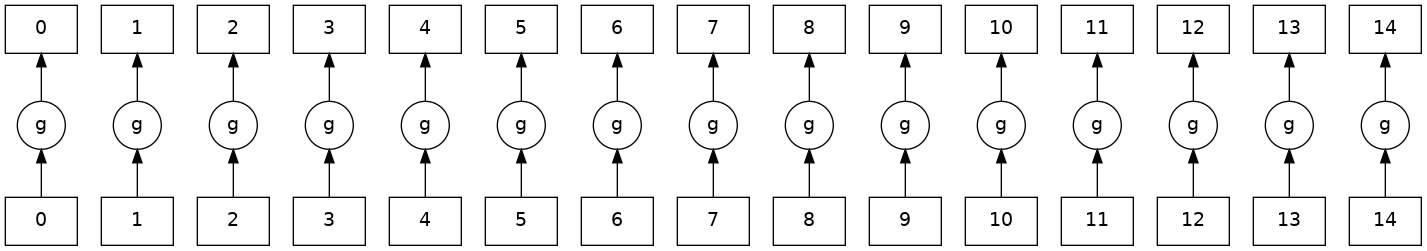

In [10]:
b = db.from_sequence(test_array, npartitions=16)
b = b.map(g)
b.visualize()

In [11]:
%%time
results_parallel = b.compute()

CPU times: user 143 ms, sys: 11.7 ms, total: 155 ms
Wall time: 929 ms


In [12]:
results_parallel = np.array(results_parallel)
results_parallel[[0, 1, 2, 3, 10, -10, -3, -2, -1]]

array([ 1.48964896,  1.40264026,  5.        ,  2.05270527, -1.48164816,
       -1.46464646, -5.        , -5.        ,  1.30063006])

- Serial: **~11 s**
- Parallel (8 workers): **~1.5 min**

Why?